# VQE on the Kagome Unit Cell

Due to the rotational symmetry of a single unit cell of the Kagome lattice, one good solution is as follows.

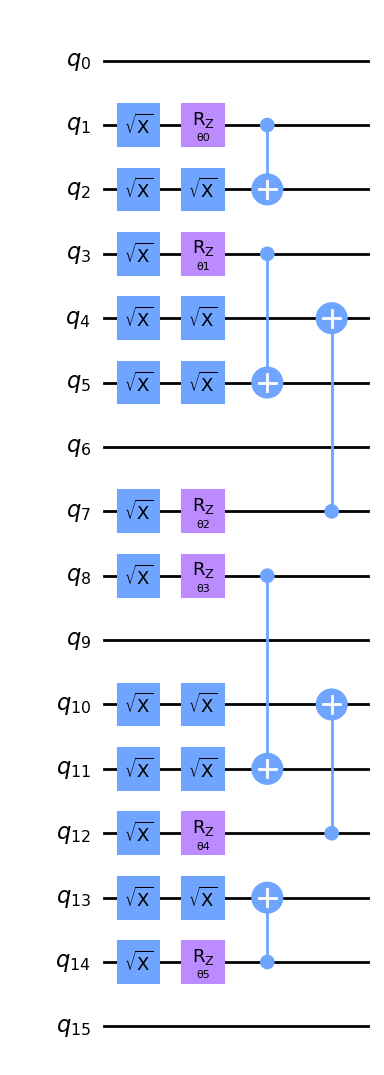

In [1]:
import numpy as np
from kagomevqe import (
    GuadalupeKagomeExtended16,
    GuadalupeKagomeRotationalSymmetry,
    KagomeHamiltonian,
)
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_ibm_runtime import Estimator, Session

ansatz = GuadalupeKagomeRotationalSymmetry()
ansatz.draw('mpl')

In [2]:

x0 = [-np.pi/2] * ansatz.num_parameters

with Session(backend="ibmq_qasm_simulator") as session:
	estimator = Estimator(session=session)
	vqe = VQE(estimator, ansatz, L_BFGS_B(), initial_point=x0)
	result = vqe.compute_minimum_eigenvalue(KagomeHamiltonian.pauli_sum_op())
	print(result)



{   'aux_operators_evaluated': None,
    'cost_function_evals': 7,
    'eigenvalue': -18.0,
    'optimal_circuit': <kagomevqe.ansatze.GuadalupeKagomeRotationalSymmetry object at 0x12e938400>,
    'optimal_parameters': {   Parameter(θ0): -1.5707963267948966,
                              Parameter(θ1): -1.5707963267948966,
                              Parameter(θ2): -1.5707963267948966,
                              Parameter(θ3): -1.5707963267948966,
                              Parameter(θ4): -1.5707963267948966,
                              Parameter(θ5): -1.5707963267948966},
    'optimal_point': array([-1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633,
       -1.57079633]),
    'optimal_value': -18.0,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x12e86da20>,
    'optimizer_time': 43.19862508773804}


However, this doesn't necessarily scale well to extensions of the lattice without that symmetry.

Here is one possible extension of the Kagome lattice using all 16 of Guadalupe's qubits.

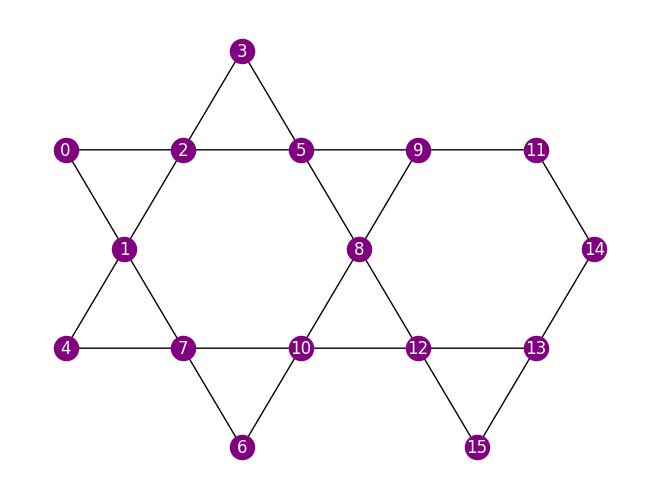

In [3]:
from kagomevqe import Kagome16AsymmetricHamiltonian

extended_lattice = Kagome16AsymmetricHamiltonian.lattice()
kagome_pos = {
    0: [0, -1],
    1: [0.5, -2],
    2: [1, -1],
    3: [1.5, 0],
    4: [0, -3],
    5: [2, -1],
    6: [1.5, -4],
    7: [1, -3],
    8: [2.5, -2],
    9: [3, -1],
    10: [2, -3],
    11: [4, -1],
    12: [3, -3],
    13: [4, -3],
    14: [4.5, -2],
    15: [3.5, -4],
}
style = {
    "with_labels": True,
    "font_color": "white",
    "node_color": "purple",
    "pos": kagome_pos,
}
extended_lattice.draw(style=style)  # type: ignore

In [4]:
ham = Kagome16AsymmetricHamiltonian.pauli_sum_op()
ansatz = GuadalupeKagomeExtended16()
x0 = [-np.pi/2] * ansatz.num_parameters

with Session(backend="ibmq_qasm_simulator") as session:
	estimator = Estimator(session=session)
	vqe = VQE(estimator, ansatz, L_BFGS_B(), initial_point=x0)
	result = vqe.compute_minimum_eigenvalue(ham)
	print(result)


{   'aux_operators_evaluated': None,
    'cost_function_evals': 207,
    'eigenvalue': -23.961999999999996,
    'optimal_circuit': <kagomevqe.ansatze.GuadalupeKagomeExtended16 object at 0x12ebba0e0>,
    'optimal_parameters': {   Parameter(θ1): -1.5707964353761135,
                              Parameter(θ0): -1.570796547059651,
                              Parameter(θ6): -1.570796661845509,
                              Parameter(θ5): -1.5707962895670506,
                              Parameter(θ2): -1.570796143757988,
                              Parameter(θ4): -1.5707964974225233,
                              Parameter(θ3): -1.5707960724046168,
                              Parameter(θ7): -1.5707963081809737},
    'optimal_point': array([-1.57079655, -1.57079644, -1.57079614, -1.57079607, -1.5707965 ,
       -1.57079629, -1.57079666, -1.57079631]),
    'optimal_value': -23.961999999999996,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimize